In [4]:
import numpy as np
import tensorflow as tf
import os
import config

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(f"Weather classes for classification:\n{config.CLASS_NAMES}")

Weather classes for classification:
['cloudy', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'shine', 'snow', 'sunrise']


In [5]:
train_data, val_data, test_data = config.load_data()

Found 7987 files belonging to 14 classes.
Using 6390 files for training.
Found 7987 files belonging to 14 classes.
Using 1597 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
from tensorflow.keras import layers, Sequential, optimizers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)
])

In [8]:
def model_builder(hp):
  
  model = Sequential([
    layers.Rescaling(1./255, input_shape=(config.IMG_HEIGHT, config.IMG_WIDTH, 3)),
    data_augmentation,
    layers.Conv2D(hp.Int("conv1", min_value=32, max_value=96, step=32), 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(hp.Int("conv2", min_value=64, max_value=128, step=32), 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(hp.Int("conv3", min_value=64, max_value=128, step=32), 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(hp.Int("dense_units", min_value=256, max_value=768, step=256), activation='relu'),
    layers.Dense(config.NUM_CLASSES)
  ])

  lr = hp.Choice("learning_rate", values=[1e-3, 1e-4])
  opt = optimizers.Adam(learning_rate=lr)

  model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
	monitor="val_loss",
	patience=config.EARLY_STOPPING_PATIENCE,
	restore_best_weights=True)

In [7]:
import sys
!{sys.executable} -m pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 2.1 MB/s eta 0:00:0000:01


In [11]:
import keras_tuner as kt

tuner = kt.Hyperband(
  model_builder,
  objective="val_accuracy",
  max_epochs=config.EPOCHS,
  factor=3,
  seed=42,
  directory="./tuner-logs",
  project_name="hyperband"
)

In [12]:
import json

tuner.search(
	x=train_data,
	validation_data=val_data,
	batch_size=config.BATCH_SIZE,
	callbacks=[early_stop],
	epochs=config.EPOCHS
)

bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of filters in conv_1 layer: {bestHP.get('conv1')}")
print(f"Optimal number of filters in conv_2 layer: {bestHP.get('conv2')}")
print(f"Optimal number of filters in conv_2 layer: {bestHP.get('conv3')}")
print(f"Optimal number of units in dense layer: {bestHP.get('dense_units')}")
print(f"Optimal learning rate: {bestHP.get('learning_rate'):.4f}")

Trial 30 Complete [01h 21m 29s]
val_accuracy: 0.6097866892814636

Best val_accuracy So Far: 0.6198243498802185
Total elapsed time: 19h 01m 17s
Optimal number of filters in conv_1 layer: 32
Optimal number of filters in conv_2 layer: 64
Optimal number of filters in conv_2 layer: 96
Optimal number of units in dense layer: 768
Optimal learning rate: 0.0010


In [13]:
with open ('models/best-hyperparams-model/compile-params.json', 'w') as f:
  json_string = json.dumps({"learning_rate": bestHP.get('learning_rate')})
  f.write(json_string)

In [10]:
hypermodel = tuner.hypermodel.build(bestHP)
hypermodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

Saving model architecture, not the entire model, because ```model.save``` produces a really big file (~200MB).

In [16]:
with open('models/best-hyperparams-model/model-architecture.json', 'w') as json_file:
    json_file.write(hypermodel.to_json())

Train model with the best hyperparams

In [11]:
hypermodel_history = hypermodel.fit(
  train_data,
  validation_data=val_data,
  batch_size=config.BATCH_SIZE,
  epochs=config.EPOCHS,
  callbacks=[early_stop]
)

Epoch 1/15
200/200 [==============================] - 313s 2s/step - loss: 1.7064 - accuracy: 0.4485 - val_loss: 1.6203 - val_accuracy: 0.4780
Epoch 2/15
200/200 [==============================] - 265s 1s/step - loss: 1.2450 - accuracy: 0.5789 - val_loss: 1.6546 - val_accuracy: 0.4668
Epoch 3/15
200/200 [==============================] - 274s 1s/step - loss: 1.0880 - accuracy: 0.6332 - val_loss: 1.4960 - val_accuracy: 0.5069
Epoch 4/15
200/200 [==============================] - 338s 2s/step - loss: 0.9953 - accuracy: 0.6601 - val_loss: 1.4787 - val_accuracy: 0.5245
Epoch 5/15
200/200 [==============================] - 322s 2s/step - loss: 0.9283 - accuracy: 0.6829 - val_loss: 1.4505 - val_accuracy: 0.5383
Epoch 6/15
200/200 [==============================] - 262s 1s/step - loss: 0.8696 - accuracy: 0.7031 - val_loss: 1.2730 - val_accuracy: 0.5922
Epoch 7/15
200/200 [==============================] - 264s 1s/step - loss: 0.8107 - accuracy: 0.7233 - val_loss: 1.3211 - val_accuracy: 0.5985

Evaluate model on yet unseen test data

In [12]:
import pandas as pd

hyper_test_metrics = hypermodel.evaluate(test_data)

metrics_table = pd.DataFrame({
  "Optimal hyperparams model": hyper_test_metrics,
})
metrics_table.index = ['loss', 'accuracy']
metrics_table

25/25 [==============================] - 10s 249ms/step - loss: 1.1975 - accuracy: 0.6137


,Optimal hyperparams model
loss,1.197513
accuracy,0.613750


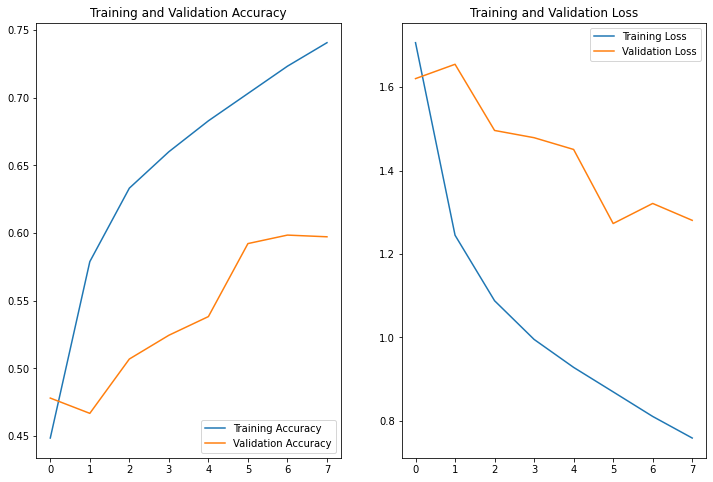

In [24]:
import helper_functions

helper_functions.visualize_training_progress(hypermodel_history.history. len(hypermodel_hystory.epoch))


1/1 [==============================] - 2s 2s/step


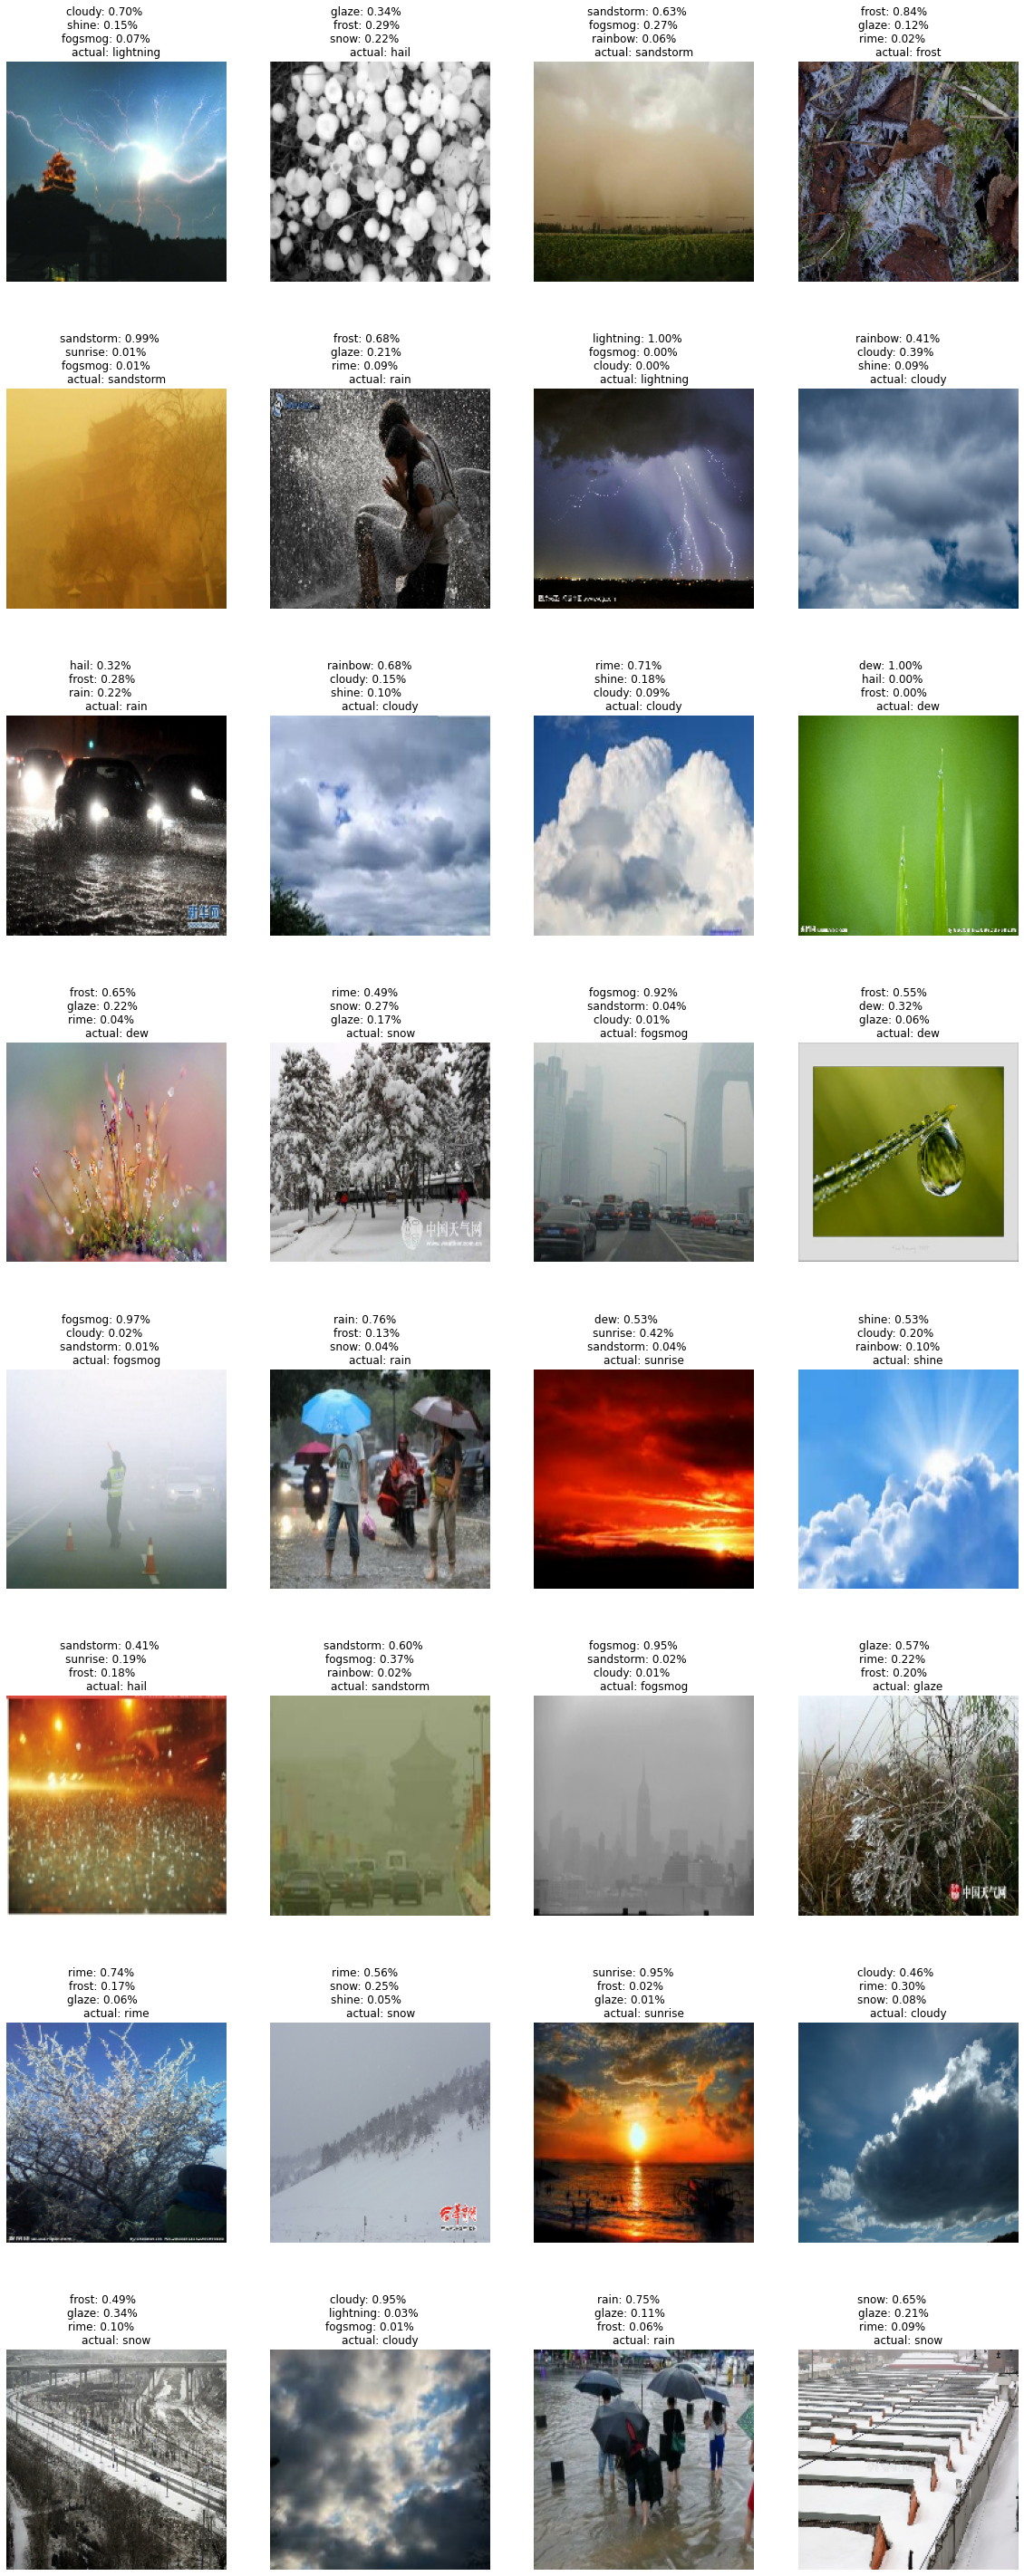

In [28]:
batch_images, batch_labels = next(iter(test_data))
hypermodel_predictions = hypermodel.predict(batch_images)
hypermodel_top_predictions = helper_functions.get_top_predictions(3, hypermodel_predictions)
helper_functions.visualize_evaluation(hypermodel_top_predictions, batch_images, batch_labels)